# ORION Inference
In this notebook we will demonstrate how to load a checkpoint, do inference on images and compare to ground-truth actions.

In [ ]:
import os
os.environ['JAX_PLATFORMS'] = 'cpu' # Force on CPU

import sys
sys.path.insert(0, '..') # Add ORCA to python path

import tensorflow as tf
import tensorflow_datasets as tfds
import rlds
import numpy as np
from PIL import Image
from IPython import display

/nfs/nfs2/users/oiermees/orca
LICENSE*      docs/         notebooks/         pyproject.toml*    setup.py*
README.md*    examples/     orca/              requirements.txt*  tests/
__pycache__/  experiments/  orca.egg-info/     run_eval.py*       train.py*
config.py*    finetune.py*  orion_eval.ipynb*  scripts/           wandb/


/nfs/nfs2/users/oiermees/miniconda3/envs/orca/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]
2023-12-09 21:28:08.995600: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-09 21:28:09.846621: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-09 21:28:09.846697: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-09 21:28:09.938102: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has alread

# Load Checkpoint
Firts we will load a checkpoint and the dataset statistics


In [ ]:
from orca.utils.pretrained_utils import PretrainedModel
model = PretrainedModel.load_pretrained("gs://rail-dibya-central2/orca_releases/20231207/orca_base_ws2")
#load dataset statistics for Freiburg "taco_play"
statistics = PretrainedModel.load_dataset_statistics("gs://rail-dibya-central2/orca_releases/20231207/orca_base_ws2","bridge_dataset") 


/nfs/nfs2/users/oiermees/miniconda3/envs/orca/lib/python3.10/site-packages/transformers/models/t5/tokenization_t5_fast.py:160: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-base automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(


# Visualize Datasets
Next, we will load a trajectory from bridge dataset

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import rlds
import numpy as np
from PIL import Image
from IPython import display
import jax
import cv2
import collections
import click
import mediapy as media

# Create a dataset object to obtain episode from

builder = tfds.builder_from_directory(builder_dir='gs://gresearch/robotics/bridge/0.1.0/')
ds = builder.as_dataset(split='train[:1]')

ds_iterator = iter(ds)
# Obtain the steps from one episode from the dataset

episode = next(ds_iterator)
steps = episode[rlds.STEPS]
steps = list(steps)
# save last image of the trajectory as a goal
goal_image = cv2.resize(np.array(steps[-1]['observation']['image']), (256,256))
#add dimension
goal_image = goal_image[np.newaxis, :, :]
images = []

for step in steps:
  im = np.array(step['observation']['image'])
  images.append(im)

print(f'{len(images)} images')
media.show_video(images, fps=10)


38 images


Prepare the task specifications, we can select to either use a language instruction or a goal image

In [ ]:
# get the natural language instruction of this trajectory
natural_language_instruction = steps[0][rlds.OBSERVATION]['natural_language_instruction'].numpy().decode()
print(natural_language_instruction)

rotate the yellow block to the left


In [ ]:
tasks_lang = model.create_tasks(texts=[natural_language_instruction])
tasks_image = model.create_tasks(goals={"image_0": goal_image}) # add ,"image_1": goal_image_wrist for wrist goal images
modality = click.prompt("Language or goal image?", type=click.Choice(["l", "g"]))
if modality == "g":
    task = tasks_image
else:
    task = tasks_lang

Language or goal image? (l, g):

  g


In [ ]:
# Jit the sample_actions function for speed
policy_fn = jax.jit(model.sample_actions)

# Inference
Now we create an observation dict with the minimum inputs to do inference. Alternatively, each model is bundled with a model.example_batch
image_0 is the name for the 3rd person camera. One can add a wrist camera into the image_1 slot.

In [ ]:
observation = {
    "image_0": np.zeros((1, 2, 256, 256,3), dtype=np.uint8), # batch, horizon, width, height, channels,
    #"image_1": np.zeros((1, 2, 128, 128,3), dtype=np.uint8), #for wrist camera
    "pad_mask": np.array([[True, True]])
}
obs_horizon = 2
# keep a queue of last 2 steps of observations
obs_deque = collections.deque(maxlen=obs_horizon)
predicted_actions = []
gt_actions = []
resized_images = []



for i, step in enumerate(steps):
  image = cv2.resize(np.array(step[rlds.OBSERVATION]['image']), (256, 256))
  resized_images.append(image)
  obs_deque.append(image)
    
  # stack the last obs_horizon number of observations
  images = np.stack([x for x in obs_deque])
    
  # add batch dimension
  images = images[np.newaxis, :, :]
  # check we have two observations
  if images.shape[1]==2:
    observation["image_0"] = images
    actions = policy_fn(observation, task, rng=jax.random.PRNGKey(0))
    #unnormalize actions
    pred_actions = (actions[0] * np.array(statistics['action']['std'])) + np.array(statistics['action']['mean'])
    predicted_actions.append(pred_actions)
    gripper_gt_act = np.array(step['action']['open_gripper']).astype(np.float32)[np.newaxis]
    gt_action = np.concatenate((step['action']['world_vector'], step['action']['rotation_delta'], gripper_gt_act), axis=-1)
    gt_actions.append(gt_action)

    

# Visualize predictions and ground-truth actions

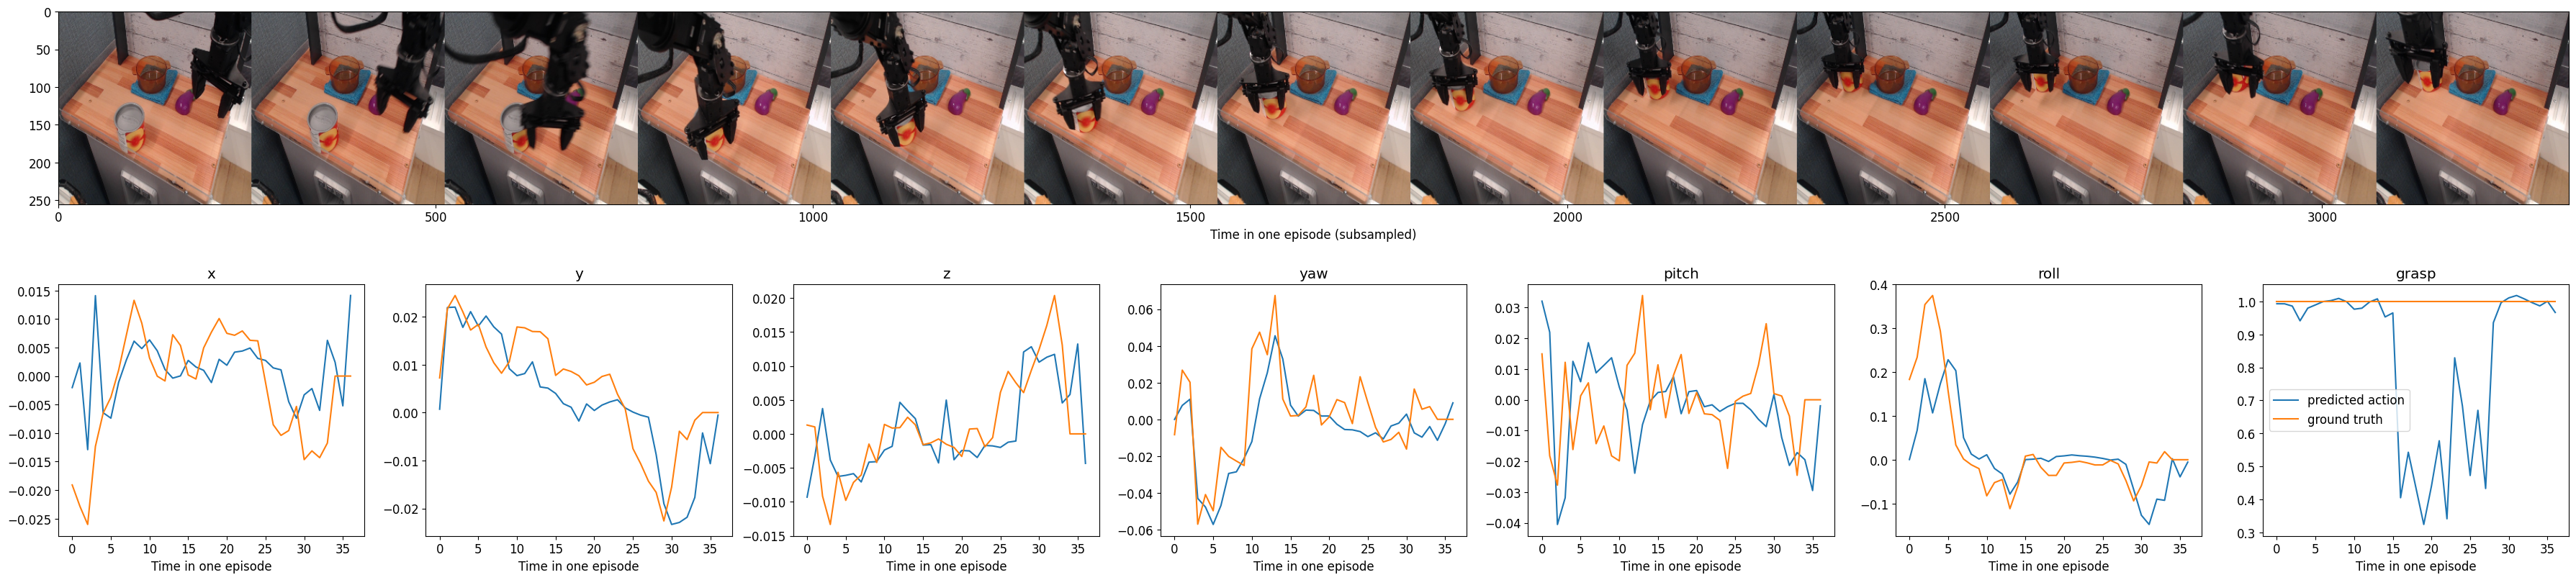

In [ ]:
import matplotlib.pyplot as plt
action_order = ['x', 'y', 'z', 'yaw', 'pitch', 'roll', 'grasp']

figure_layout = [
    ['image'] * len(action_order),
    action_order
]

plt.rcParams.update({'font.size': 12})


select_imgs = np.concatenate(np.array(resized_images[::3]), axis=1)
predicted_actions = np.array(predicted_actions).squeeze()
gt_actions = np.array(gt_actions).squeeze()

# fig, axs = plt.subplots(1, len(action_name_to_values_over_time))
fig, axs = plt.subplot_mosaic(figure_layout)
fig.set_size_inches([45, 10])

for action_dim, action_name in enumerate(action_order):
  axs[action_name].plot(predicted_actions[:, action_dim], label='predicted action')
  axs[action_name].plot(gt_actions[:, action_dim], label='ground truth')

  axs[action_name].set_title(action_name)
  axs[action_name].set_xlabel('Time in one episode')

axs['image'].imshow(select_imgs)
axs['image'].set_xlabel('Time in one episode (subsampled)')
#axs['image'].set_title(f'{task=}')

plt.legend()
